In [1]:
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
from sqlalchemy import create_engine
import pickle 
from politenessr import Politenessr
from transformers import XLMRobertaTokenizer
from thefuzz import fuzz

tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

/home/shreyah/.conda/envs/politeness/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shreyah/.conda/envs/politeness/lib/python3.8/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def read_pickle(file_path):
    with open(file_path, 'rb') as file:
        pickle_file = pickle.load(file)
    return pickle_file

en_dialog = read_pickle("dialog_acts/dialog_act_data/english_dialog_acts_updated.p")
es_dialog = read_pickle("dialog_acts/dialog_act_data/spanish_dialog_acts_updated.p")
ja_dialog = read_pickle("dialog_acts/dialog_act_data/japanese_dialog_acts_updated.p")
zh_dialog = read_pickle("dialog_acts/dialog_act_data/chinese_dialog_acts_updated.p")

en_shap = read_pickle("shapley/xlm_shap_values/UPDATED/english.p")
es_shap = read_pickle("shapley/xlm_shap_values/UPDATED/spanish.p")
ja_shap = read_pickle("shapley/xlm_shap_values/UPDATED/japanese.p")
zh_shap = read_pickle("shapley/xlm_shap_values/UPDATED/chinese.p")

In [3]:
def get_token_level_shapley_values(shap_pickle, tokenizer):
    token_level_shapley_values = []
    utterances = []
    shap_data = shap_pickle.data
    shap_values = shap_pickle.values
    shap_base = shap_pickle.base_values
    for idx in tqdm(range(len(shap_data))):
        tokens = shap_data[idx]
        values = shap_values[idx]
        base = shap_base[idx]

        # divide base amongst all tokens
        base_add = base/len(tokens)
        values = [v + base_add for v in values]
        
        utterance_string = tokenizer.convert_tokens_to_string(tokens)
        utterances.append(utterance_string)
        token_level_shapley_values.append([tokens, values, base])
    return utterances, token_level_shapley_values

def process_tokens(token_list):
    #remove all spaces and punctuation from token that are added by tokenizer
    to_replace = [" ", "_", "▁", ".", ",", "\n", ")", "(", "[", "]"]
    for r in to_replace:
        token_list = [x.replace(r, "") for x in token_list]
    #make all lowercase
    token_list = [str(x).lower().strip() for x in token_list]
    #remove all empty strings
    return token_list

def get_start_end_idxs(shap_tokens, match_tokens, fuzz_threshold):
    start_idx = -1
    end_idx = -1

    max_fuzz = fuzz_threshold

    processed_shap_tokens = process_tokens(shap_tokens)
    processed_match_tokens = process_tokens(match_tokens)

    match_sent = tokenizer.convert_tokens_to_string(match_tokens)

    for j in range(len(processed_shap_tokens)):
        if(processed_shap_tokens[j] == processed_match_tokens[0]):
            sent_1 = tokenizer.convert_tokens_to_string(shap_tokens[j:j+len(match_tokens)])
            sent_2 = tokenizer.convert_tokens_to_string(shap_tokens[j:min(j+len(match_tokens)+1, len(shap_tokens))])
            sent_3 = tokenizer.convert_tokens_to_string(shap_tokens[j:min(j+len(match_tokens)+2, len(shap_tokens))])
            fuzz1 = fuzz.ratio(sent_1, match_sent)
            fuzz2 = fuzz.ratio(sent_2, match_sent)
            fuzz3 = fuzz.ratio(sent_3, match_sent)
            if(fuzz1 > max_fuzz):
                start_idx = j
                end_idx = j+len(match_tokens)
                max_fuzz = fuzz1
            if(fuzz2 > max_fuzz):
                start_idx = j
                end_idx = j+len(match_tokens)+1
                max_fuzz = fuzz2
            if(fuzz3 > max_fuzz):
                start_idx = j
                end_idx = j+len(match_tokens)+2
                max_fuzz = fuzz3
    return start_idx, end_idx

def string_to_list(string):
    string = string.replace("[", "")
    string = string.replace("]", "")
    list_items = string.split("\",")
    final_items = []
    for item in list_items:
        split_items = item.split("\',")
        for i in range(len(split_items)):
            final_items.append(split_items[i])
    for i in range(len(final_items)):
        final_items[i] = final_items[i].strip()
        final_items[i] = final_items[i][1:]
    return final_items

def process_dialog_acts(dialog_labels):
    for i in range(len(dialog_labels)):
        dialog_labels[i] = str(dialog_labels[i])
        dialog_labels[i] = dialog_labels[i].replace("[", "")
        dialog_labels[i] = dialog_labels[i].replace("]", "")
        dialog_labels[i] = dialog_labels[i].replace("'", "")
        dialog_labels[i] = dialog_labels[i].replace(",", "")
        dialog_labels[i] = dialog_labels[i].replace("(", "")
        dialog_labels[i] = dialog_labels[i].replace(")", "")
        dialog_labels[i] = dialog_labels[i].strip()
    return dialog_labels


def get_sentence_shapley(shapley_values, dialog_acts, fuzz_threshold=70, return_sentences=False):
    _, shap_object = get_token_level_shapley_values(shapley_values, tokenizer)
    no_match_count = 0
    shap_sentence_vals = []
    dialog_sentence_labels = []
    raw_sentences = []
    assert(len(shapley_values) == len(dialog_acts))
    for i in range(len(shapley_values)):
        sentences = dialog_acts["Sentences"][i]
        split_sentences = string_to_list(sentences)
        
        dialog_labels = dialog_acts["Dialog Acts"][i]
        dialog_labels = process_dialog_acts(dialog_labels)
        try:
            assert(len(split_sentences) == len(dialog_labels))
        except(AssertionError):
            continue
        
        local_sentence_vals = []
        shap_tokens = shap_object[i][0]
        for sent in split_sentences:
            match_tokens = tokenizer.tokenize(sent)
            start_idx, end_idx = get_start_end_idxs(shap_tokens, match_tokens, fuzz_threshold)
            if(start_idx == -1 or end_idx == -1):
                start_idx, end_idx = get_start_end_idxs(shap_tokens, match_tokens[1:], fuzz_threshold)
            if(start_idx == -1 or end_idx == -1):
                start_idx, end_idx = get_start_end_idxs(shap_tokens, match_tokens[2:], fuzz_threshold)
            if(start_idx == -1 or end_idx == -1):
                no_match_count += 1
            total_value = np.sum(shap_object[i][1][start_idx:end_idx])
            local_sentence_vals.append(total_value)
        shap_sentence_vals.append(local_sentence_vals)
        dialog_sentence_labels.append(dialog_labels)
        raw_sentences.append(split_sentences)

    print("No match count: %d" % no_match_count)
    if(return_sentences):
        return shap_sentence_vals, dialog_sentence_labels, raw_sentences
    return shap_sentence_vals, dialog_sentence_labels


In [5]:
shap_sent_en, dialog_labels_en = get_sentence_shapley(en_shap, en_dialog, 80)
shap_sent_es, dialog_labels_es = get_sentence_shapley(es_shap, es_dialog, 80)
shap_sent_ja, dialog_labels_ja = get_sentence_shapley(ja_shap, ja_dialog, 60)
shap_sent_zh, dialog_labels_zh = get_sentence_shapley(zh_shap, zh_dialog, 60)

100%|██████████| 5700/5700 [00:00<00:00, 8774.64it/s]


No match count: 4


100%|██████████| 5699/5699 [00:00<00:00, 8711.06it/s]


No match count: 6


100%|██████████| 5699/5699 [00:00<00:00, 9001.20it/s] 


No match count: 4


100%|██████████| 5700/5700 [00:00<00:00, 7243.59it/s] 


No match count: 6


In [4]:
def get_dialog_mapping(shap_sent, dialog_labels):
    assert(len(shap_sent) == len(dialog_labels))
    shap_dialog_mapping = {}
    shap_sent_flatten = np.concatenate(shap_sent)
    dialog_labels_flatten = np.concatenate(dialog_labels)
    for i in range(len(shap_sent_flatten)):
        dialog_acts_split = dialog_labels_flatten[i].split(" ")
        for split_act in dialog_acts_split:
            split_act = split_act.strip()
            try:
                shap_dialog_mapping[split_act].append(shap_sent_flatten[i])
            except(KeyError):
                shap_dialog_mapping[split_act] = [shap_sent_flatten[i]]
    return shap_dialog_mapping

In [6]:
dialog_act_categories = {
    "Statement_non_opinion": ["sd"],
    "Statement_opinion": ["sv"],
    "Future_action": ["oo", "ad", "cc"],
    "Questions": ["qy", "qw", "qo", "qr", "qrr", "^d", "^g"],
    "Conventional_dialog": ["fp", "fc", "fx", "fe", "ft", "fw", "fa"],
    "Agreement": ["aa", "aap", "am", "arp", "ar", "^h"],
    "Understanding": ["br", "br^m", "b", "bh", "bk", "^m", "^2", "bf", "ba", "by", "bd", "bc"],
    "Answer": ["ny", "nn", "na", "nd", "ng", "no", "sd^e", "sv^e", "^e", "nn^e", "ny^e"],
}

dialog_act_labels = {
    "s": "Statement",
    "sd": "Declarative Statement",
    "sv": "Opinion Statement",
    "oo": "Open-option",
    "qy": "Yes/No Question",
    "qw": "Wh-Question",
    "qo": "Open-Question",
    "qr": "Or-Question",
    "qrr": "Or-Clause",
    "qh": "Rhetorical-Question",
    "^d": "Declarative-Question",
    "qy^d": "Declarative-Yes-No-question",
    "^g": "Tag-Question",
    "ad": "Action-directive",
    "co": "Offer",
    "cc": "Commit",
    "fp": "Conventional Opening",
    "fc": "Conventional Closing",
    "fx": "Explicit-performative",
    "fe": "Exclamation",
    "fo": "Other-forward-function",
    "ft": "Forward-Function: Thanking",
    "fw": "You're-Welcome",
    "fa": "Apology",
    "aa": "Accept",
    "aap": "Accept-part",
    "am": "Maybe",
    "arp": "Reject-part",
    "ar": "Reject",
    "^h": "Hold before answer/agreement",
    "br": "Signal-non-understanding",
    "br^m": "Signal-non-understanding",
    "b": "Acknowledge",
    "bh": "Acknowledge",
    "bk": "Acknowledge-answer",
    "^m": "Repeat-phrase",
    "^2": "Completion",
    "bf": "Summarize/reformulate",
    "ba": "Appreciation",
    "by": "Sympathy",
    "bd": "Downplayer",
    "bc": "Correct-misspeaking",
    "ny":  "Yes answers",
    "nn":  "No answers",
    "na":  "Affirmative non-yes answers",
    "nd":  "Dispreferred answers",
    "ng":  "Negative non-no answers",
    "no":  "Other answers",
    "sd^e": "Statement expanding y/n answer",
    "sv^e": "Statement expanding y/n answer",
    "^e":  "Expansions of y/n answers",
    "nn^e": "No plus expansion",
    "ny^e": "Yes plus expansion",
    "^q":  "Quoted material",
}

In [7]:
mapping_en = get_dialog_mapping(shap_sent_en, dialog_labels_en)
mapping_es = get_dialog_mapping(shap_sent_es, dialog_labels_es)
mapping_ja = get_dialog_mapping(shap_sent_ja, dialog_labels_ja)
mapping_zh = get_dialog_mapping(shap_sent_zh, dialog_labels_zh)

def get_grouped_mapping(mapping):
    #group into categories
    mapping_grouped = {x:[] for x in dialog_act_categories.keys()}
    for category in dialog_act_categories:
        print("----", category, "----")
        subkeys = dialog_act_categories[category]
        for subkey in subkeys:
            try:
                mapping_grouped[category].extend(mapping[subkey])
                print(subkey, "count: ", len(mapping[subkey]), "mean: ", np.mean(mapping[subkey]), "std: ", np.std(mapping[subkey]))
            except(KeyError):
                # print("KeyError: %s" % subkey)
                continue
    print('\n')
    return mapping_grouped

def aggregate_shap_vals(mapping):
    mapping_aggregated = {}
    for category in mapping:
        if(len(mapping[category]) < 10):
            continue
        mapping_aggregated[category] = np.sum(mapping[category])
    return mapping_aggregated


mapping_en_grouped = get_grouped_mapping(mapping_en)
mapping_es_grouped = get_grouped_mapping(mapping_es)
mapping_ja_grouped = get_grouped_mapping(mapping_ja)
mapping_zh_grouped = get_grouped_mapping(mapping_zh)

en_agg = aggregate_shap_vals(mapping_en)
es_agg = aggregate_shap_vals(mapping_es)
ja_agg = aggregate_shap_vals(mapping_ja)
zh_agg = aggregate_shap_vals(mapping_zh)

---- Statement_non_opinion ----
sd count:  9223 mean:  0.0801349432327082 std:  0.42426847135863277
---- Statement_opinion ----
sv count:  3328 mean:  -0.05185103576303775 std:  0.4856655637295028
---- Future_action ----
oo count:  14 mean:  -0.040052725476172675 std:  0.4852233218502627
ad count:  333 mean:  0.09529514763919054 std:  0.4167343091118238
---- Questions ----
qy count:  716 mean:  0.04213253269266299 std:  0.5142773717660551
qw count:  284 mean:  -0.3338208080617995 std:  0.3846169461650134
qo count:  79 mean:  -0.3091186935712836 std:  0.5017336625526878
qrr count:  19 mean:  -0.18410919048671007 std:  0.46389052683746934
---- Conventional_dialog ----
fp count:  81 mean:  0.6626787332441936 std:  0.4278705641839541
fc count:  109 mean:  0.6015791603513562 std:  0.7092942426548772
fx count:  6 mean:  0.5759431894287348 std:  0.37586263699234923
ft count:  66 mean:  0.9118245781780898 std:  0.6112585302836192
fa count:  55 mean:  0.44534654233695264 std:  0.847770091315203

9223 8412 6988 7356
sd
Declarative Statement


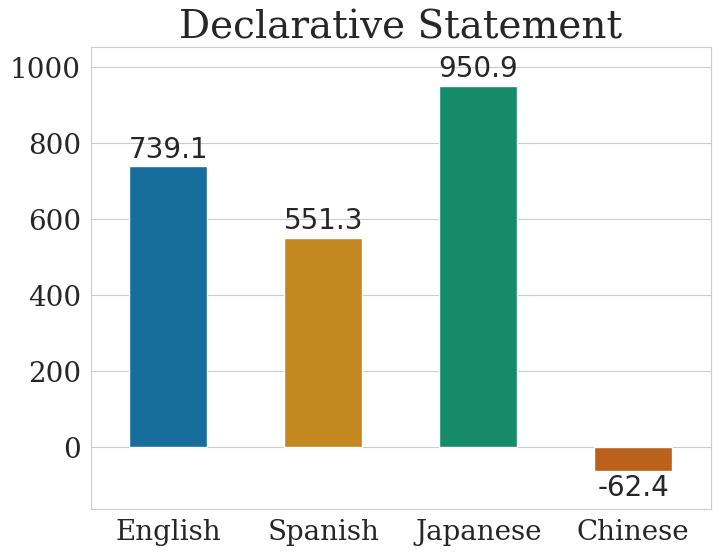

716 508 570 714
qy
Yes/No Question


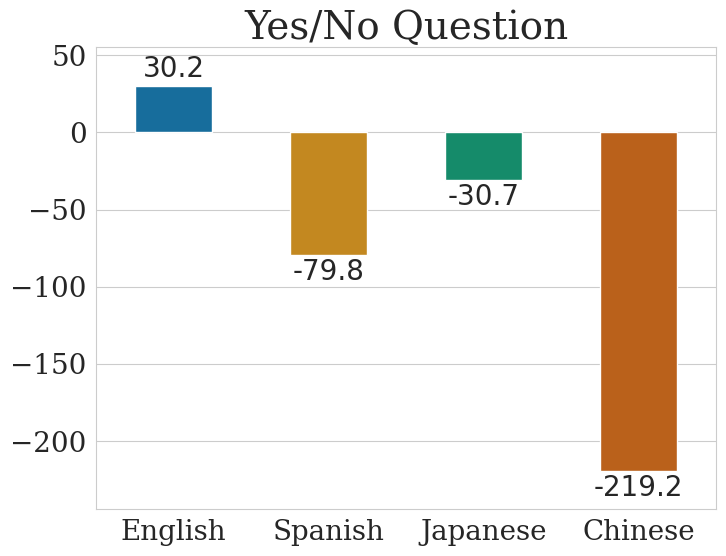

109 106 506 105
fc
Conventional Closing


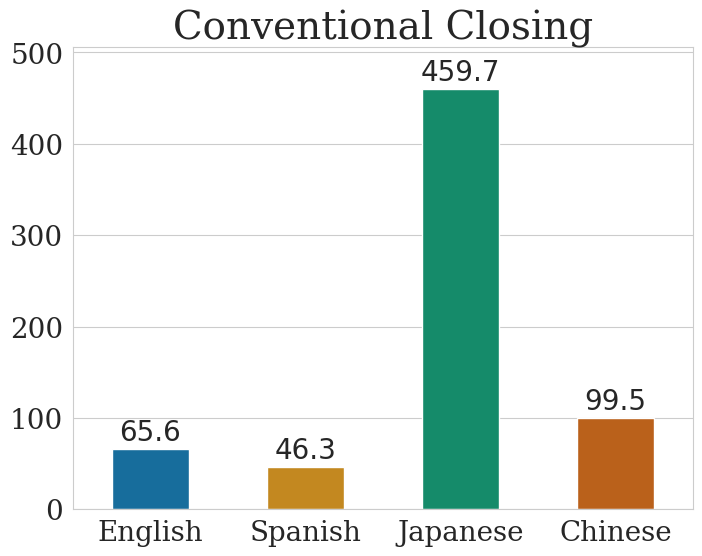

311 261 296 126
aa
Accept


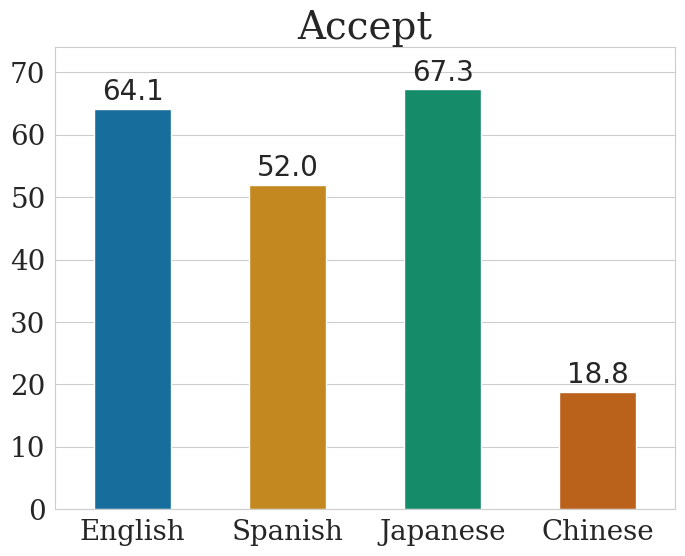

116 179 267 450
^q
Quoted material


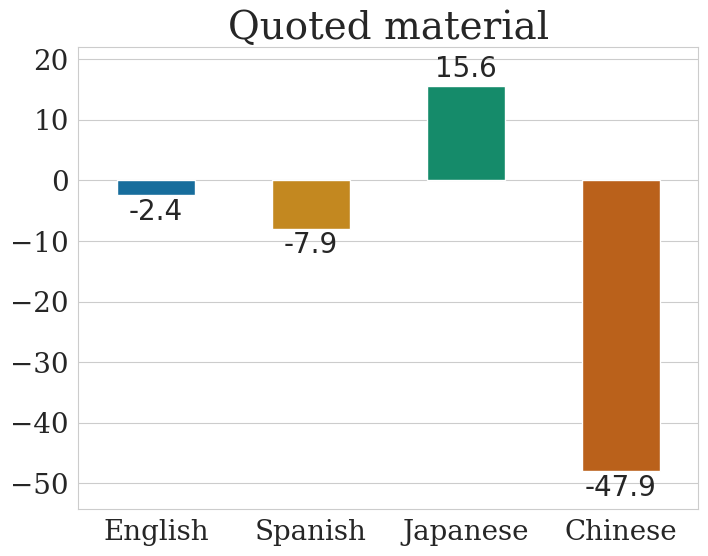

KeyError: 
333 177 283 295
ad
Action-directive


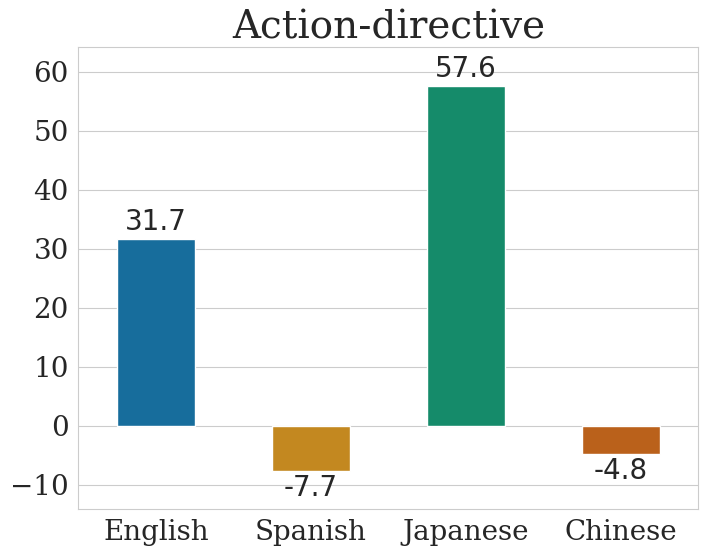

284 259 164 284
qw
Wh-Question


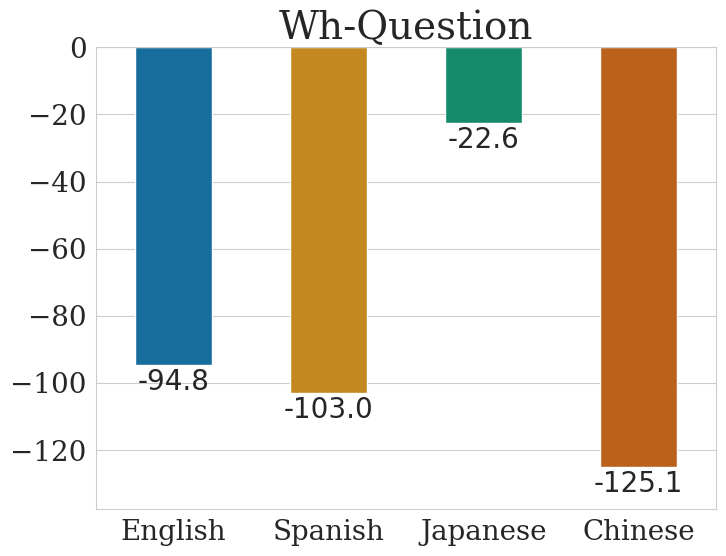

3328 3769 2482 3215
sv
Opinion Statement


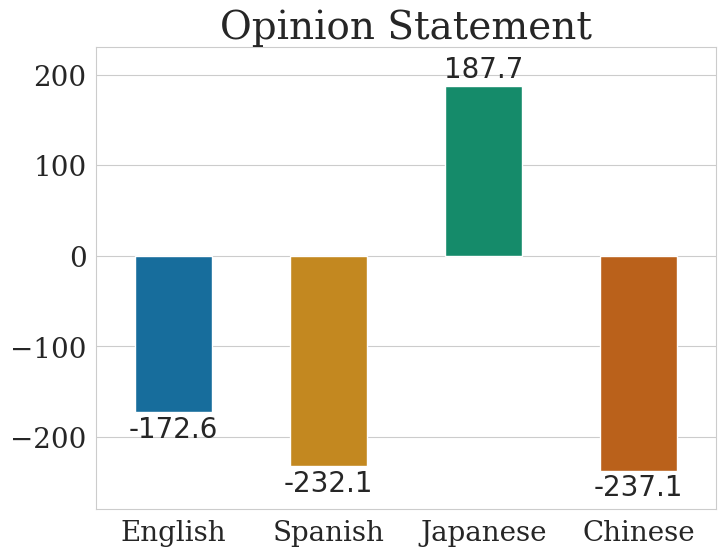

79 73 81 93
qo
Open-Question


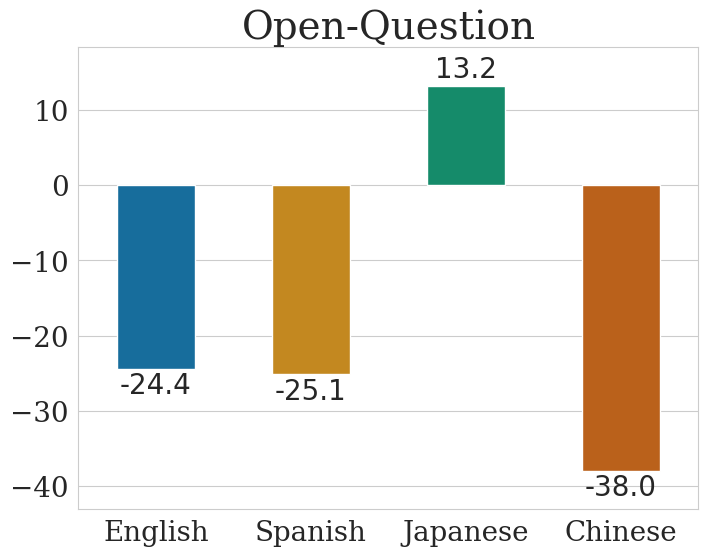

36 30 19 25
no
Other answers


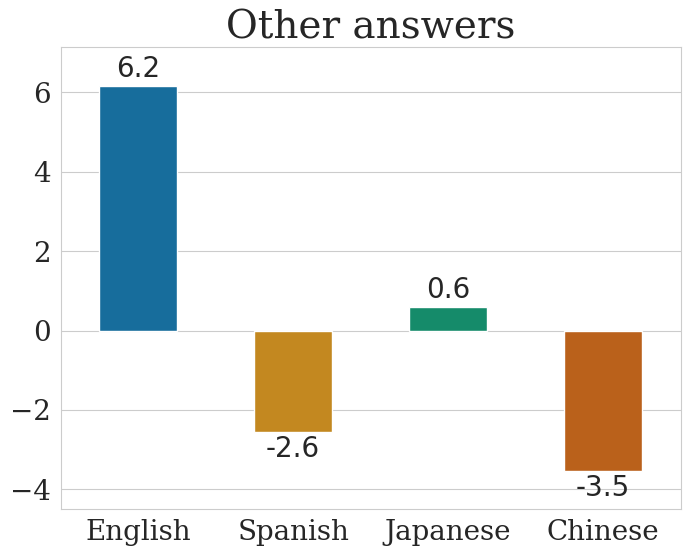

123 83 58 84
qy^d
Declarative-Yes-No-question


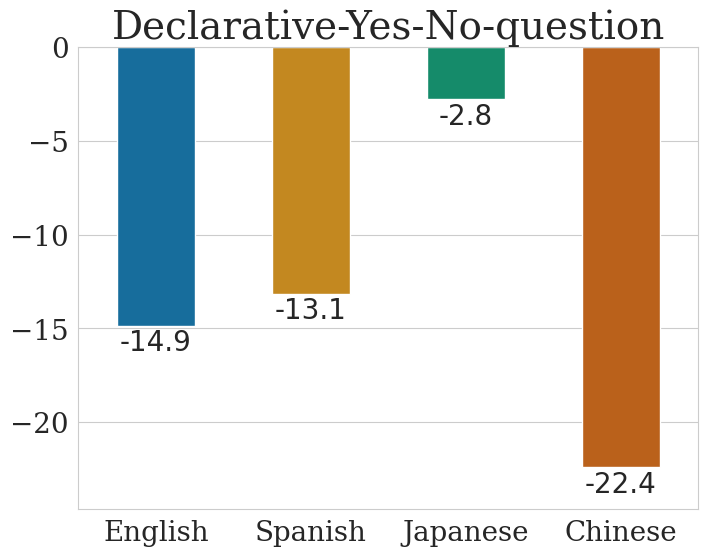

81 175 152 31
fp
Conventional Opening


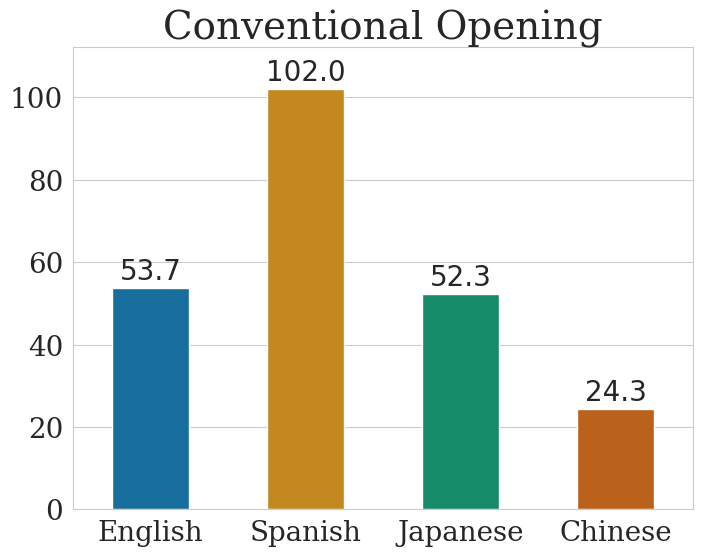

55 52 243 47
fa
Apology


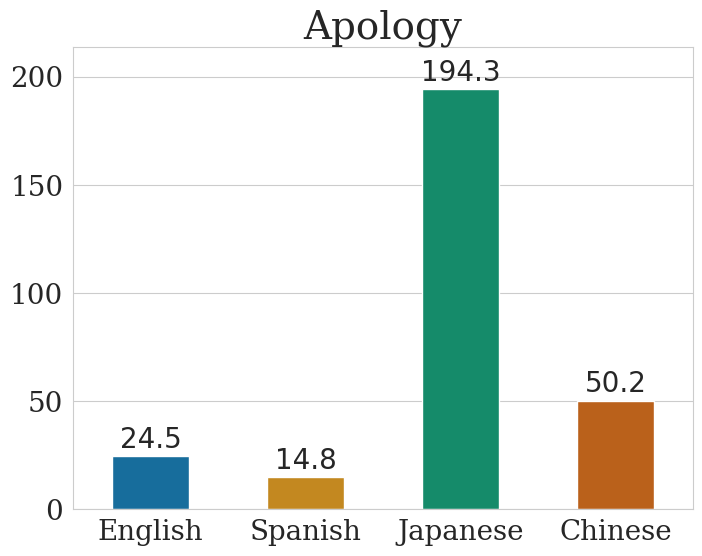

29 34 65 47
^2
Completion


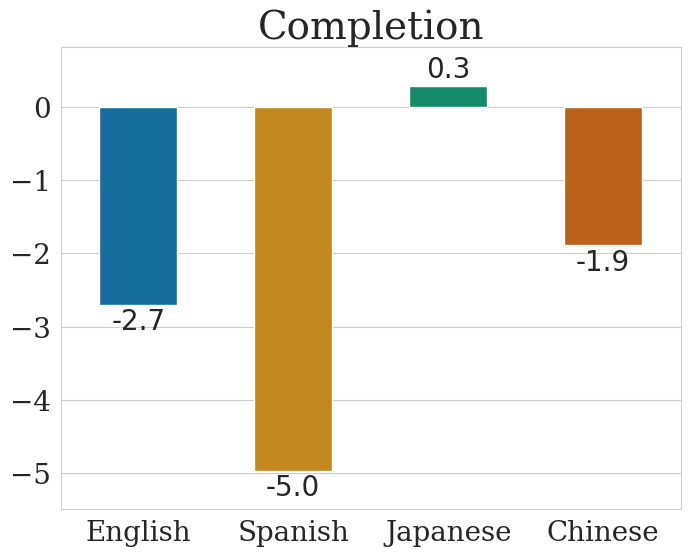

66 79 246 119
ft
Forward-Function: Thanking


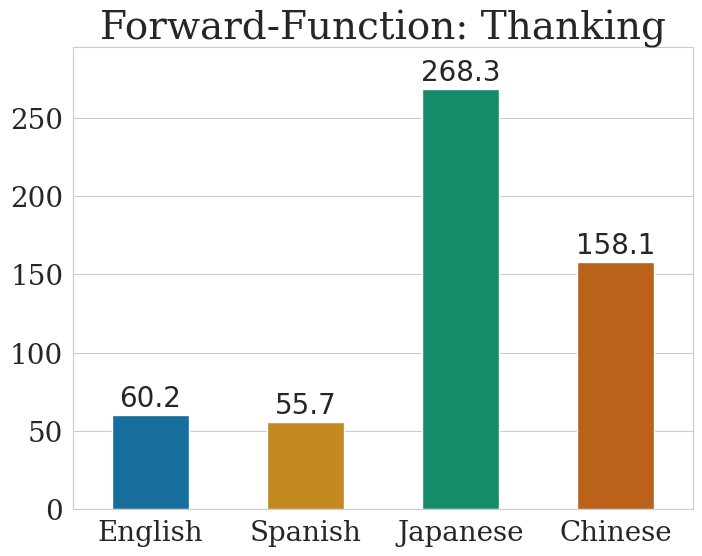

KeyError: t3
KeyError: +
16 16 41 19
ba
Appreciation


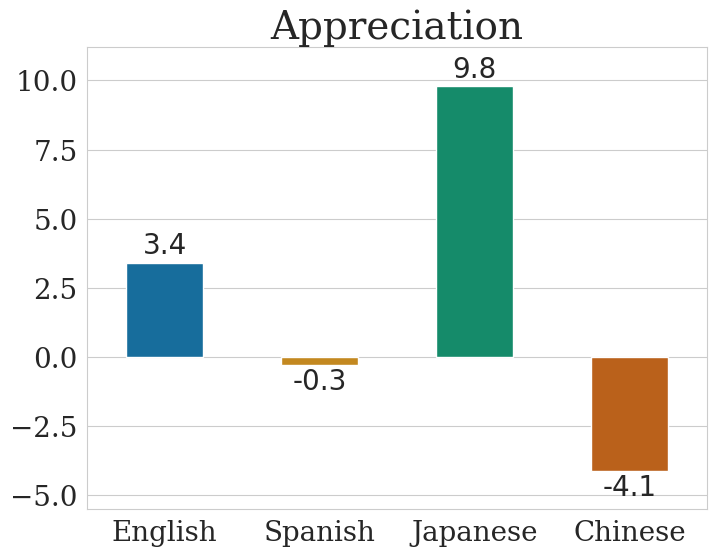

89 68 37 104
qh
Rhetorical-Question


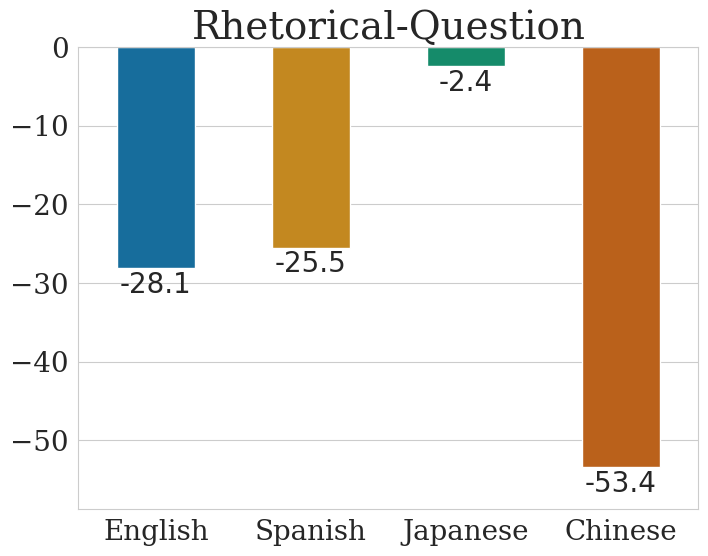

48 22 19 19
ng
Negative non-no answers


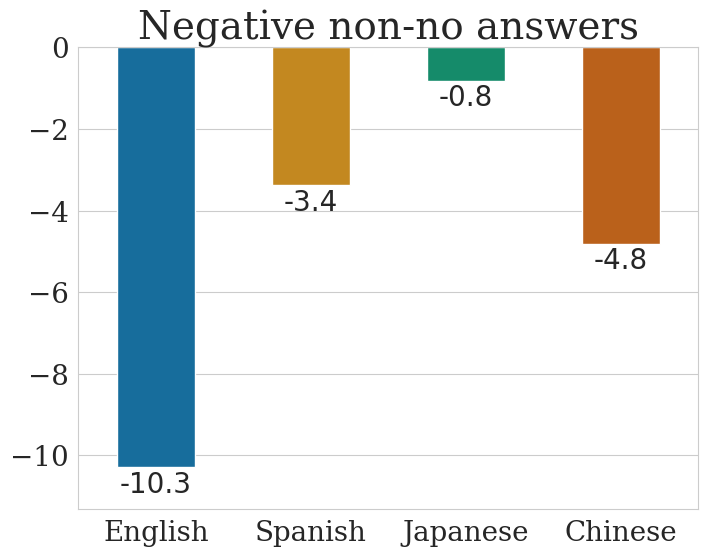

51 50 49 54
bf
Summarize/reformulate


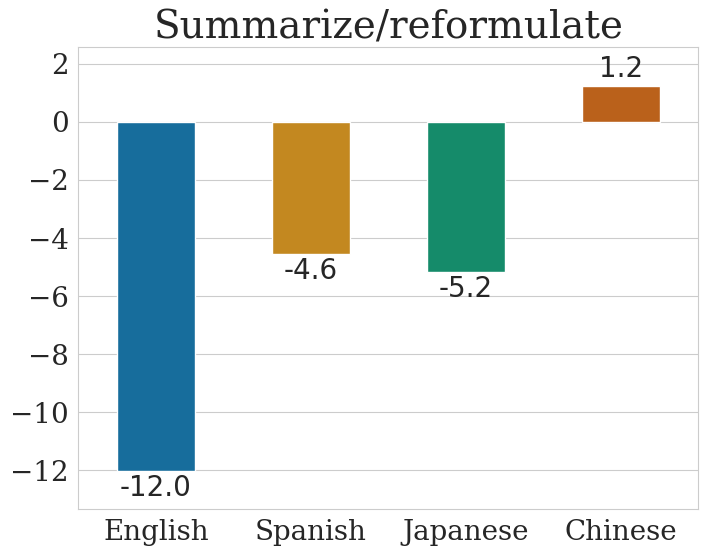

14 19 34 23
oo
Open-option


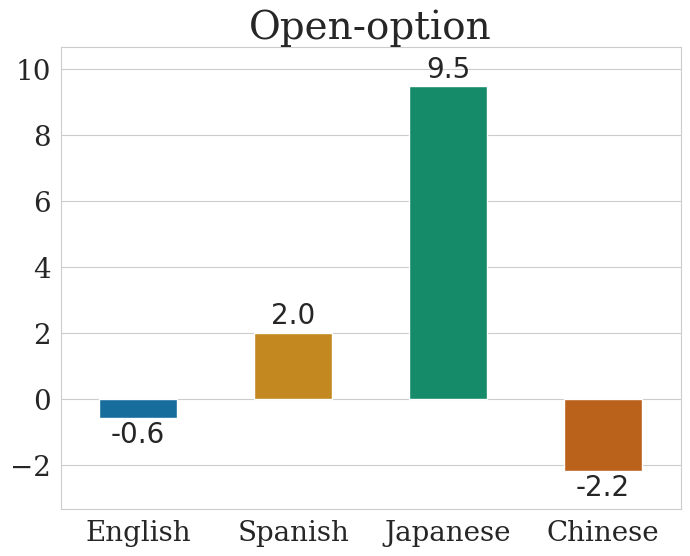

In [40]:
#make bar graphs for each dialog act category
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dialog_mapping(mapping, act, legend):
    try:
        title = dialog_act_labels[act]
    except(KeyError):
        print("KeyError: %s" % act)
        return
    #print counts
    print(len(mapping_en[act]), len(mapping_es[act]), len(mapping_ja[act]), len(mapping_zh[act]))
    plt.rcParams['font.family'] = 'serif'

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.set_style("whitegrid")
    print(act)
    # plt.hist(mapping, bins=10, label=legend)

    # for a in mapping:
    #     sns.histplot(a, bins=20, ax=ax, kde=False)

    sns.barplot(x=legend, y=mapping, ax=ax, width=0.5,palette='colorblind')
    print(title)
    ax.set_title(title, fontsize=28)
    # ax.set_ylabel("Average Shapley Value", fontsize=12)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.margins(y=0.1)
    ax.bar_label(ax.containers[0], fmt='%.1f', label_type='edge', padding=2, fontsize=20)
    # ax.legend(loc='upper right', fontsize=12)

    plt.show()

def make_all_plots(mapping_list, legend_list):
    for key in mapping_list[0]:
        try:
            plot_dialog_mapping([mapping_list[0][key],mapping_list[1][key],mapping_list[2][key],mapping_list[3][key]], key, legend=legend_list)
        except(KeyError):
            continue

legend=["English", "Spanish","Japanese", "Chinese"]
make_all_plots([en_agg, es_agg, ja_agg, zh_agg], legend)
# make_all_plots([mapping_en_grouped, mapping_es_grouped, mapping_ja_grouped, mapping_zh_grouped], legend)





In [43]:
shap_sent_en, dialog_labels_en, raw_sentences_en = get_sentence_shapley(en_shap, en_dialog, 80, return_sentences=True)

100%|██████████| 5700/5700 [00:00<00:00, 7398.01it/s]


No match count: 4


In [51]:
TARGET = "qy"
dialog_flatten = np.concatenate(dialog_labels_en)
sent_flatten = np.concatenate(raw_sentences_en)

for i in range(len(dialog_flatten)):
    if(TARGET == dialog_flatten[i]):
        print(sent_flatten[i])

Let's knock any 'EngVar' shenanigans on the head right away, shall we?
Is it true that he originally gave this film two stars?
UCSF STUDENT 2 – Are the points included verifiable with cited secondary sources that are freely accessible?
Is there a significant risk of disease from having him around here?
Messner repeated Nanga Parbat in 1978 after climbing it in 1970 as his first 8000er, so should we start Messner's time taken from Manaslu (1972, his second 8000er)?"
If you are concerned about copyright, perhaps it would be best to paraphrase and then make a formal reference to it as a source?'
Common knowledge or painfully obvious?
Blueboar, can you point me to a documented case like you describe?
Could somebody check that one out as well, as I'm not sure how to do that?
Can we add information about the training and sale of working dogs.
Can a native German speaker comment on whether 'Münster'/'Dom' designations take on the feel as if it is part of the proper name of the building?
Any e

In [ ]:
shap_sent_en[0:4]

[[0.23718503395646393, -0.09502893434443946, 1.6720193034746276],
 [-0.22665040278989906, 1.3809471455942683],
 [1.099722200206348, 0.9358411370491495, 1.4541250078045593],
 [1.107716533688673, 0.5763283156334085, 0.9008142136512918]]

In [ ]:
np.concatenate(shap_sent_en[0:4])

array([ 0.23718503, -0.09502893,  1.6720193 , -0.2266504 ,  1.38094715,
        1.0997222 ,  0.93584114,  1.45412501,  1.10771653,  0.57632832,
        0.90081421])